In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('ufc_ml_dataset.csv', parse_dates=['DATE'])
df['year'] = df['DATE'].dt.year

# Potential X & y
Quite a few columns were kept in the ML dataset in case they would be useful. But let's start to hone in on the ones we really want to experiment with.

In [3]:
cols_of_interest = [
    'Red_Victory', # Dep Var
    # 'EVENT', # Text
    # 'BOUT', # Already extracted what we need
    # 'OUTCOME', # Already extracted what we need
    # 'WEIGHTCLASS',
    # 'METHOD',
    'ROUND',
    # 'TIME',
    'TIME FORMAT',
    # 'REFEREE', # Cardinality too high (225 distinct)
    # 'DETAILS', # Text
    # 'URL_fight',
    # 'FIGHTER_Red',
    # 'FIGHTER_Blue',
    # 'URL_event',
    # 'DATE', # TODO drop one of these dates
    # 'LOCATION',
    # 'EVENT_DATE',
    'gender',
    'weightclass',
    'STANCE_Red',
    # 'DOB_Red',
    'HEIGHT_in_Red',
    'WEIGHT_lbs_Red',
    'REACH_in_Red',
    'FIGHTER',
    'STANCE_Blue',
    'DOB_Blue',
    'HEIGHT_in_Blue',
    'WEIGHT_lbs_Blue',
    'REACH_in_Blue',
    'Age_yrs_Red',
    'Age_yrs_Blue',
    'WEIGHT_lbs_diff',
    'HEIGHT_in_diff',
    'REACH_in_diff',
    'Age_diff',
    'STANCE_diff',
    'Red_prior_fights',
    'Red_prior_victories',
    'Red_prior_losses',
    'Red_prior_f_win',
    'Blue_prior_fights',
    'Blue_prior_victories',
    'Blue_prior_losses',
    'Blue_prior_f_win',
    'year'
]

df = df[cols_of_interest]

In [4]:
text_cols = df.dtypes[df.dtypes == 'object'].index
num_cols = df.dtypes[df.dtypes == 'float64'].index

# Missingness

## Overall

In [5]:
px.line(
    df.isna().mean().sort_values(ascending=False).to_frame().rename(columns={0: 'Missing Rate'}).reset_index(),
    x='index',
    y='Missing Rate',
    markers=True
)

## By Year

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_missing_by_year = pd.merge(
    df.groupby('year', as_index=False).size().rename(columns={'size': 'Data Points'}),
    df.dropna().groupby('year', as_index=False).size().rename(columns={'size': 'Non-Null'}),
    on='year'
)

df_missing_by_year['Fraction Missing'] = 1 - (df_missing_by_year['Non-Null'] / df_missing_by_year['Data Points'])

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=df_missing_by_year['year'],
        y=df_missing_by_year['Data Points'],
        name='Data Points',
        mode='lines+markers'
    ),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(
        x=df_missing_by_year['year'],
        y=df_missing_by_year['Fraction Missing'],
        name='Fraction Missing',
        mode='lines+markers'
    ),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="Data Points", secondary_y=False)
fig.update_yaxes(title_text="Fraction Missing", secondary_y=True)

fig.show()


## Drop remaining NA
This can be revisited. For now we want to move onto modeling so dropping rows with any missing values for the features of interest

In [7]:
print(len(df.index))
df = df.dropna()
print(len(df.index))


7882
7434


In [8]:
# missing_rate_by_year = 
# df.groupby('year').size() / 
df.groupby('year')['Age_diff']

# Class balance by year
Prior to the year 2010 the Red victory rate was 100%. This is most likely an artifact of how the data was scraped. In the UFC stats website, older fights always list the winner as the top fighter.

<Axes: xlabel='year'>

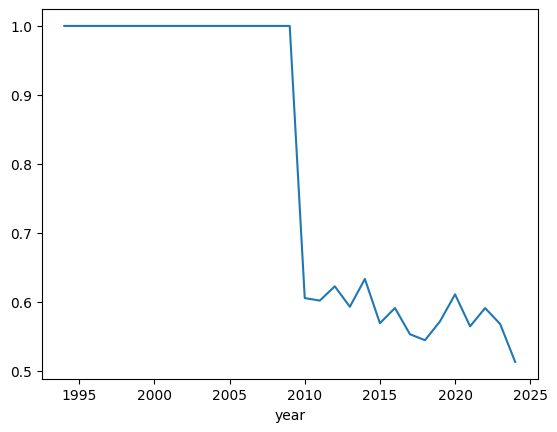

In [9]:
df.groupby('year')['Red_Victory'].mean().plot()

In [10]:
# Remove data prior to 2010
df = df[df['year'] >= 2010]
len(df.index)

6397

<Axes: >

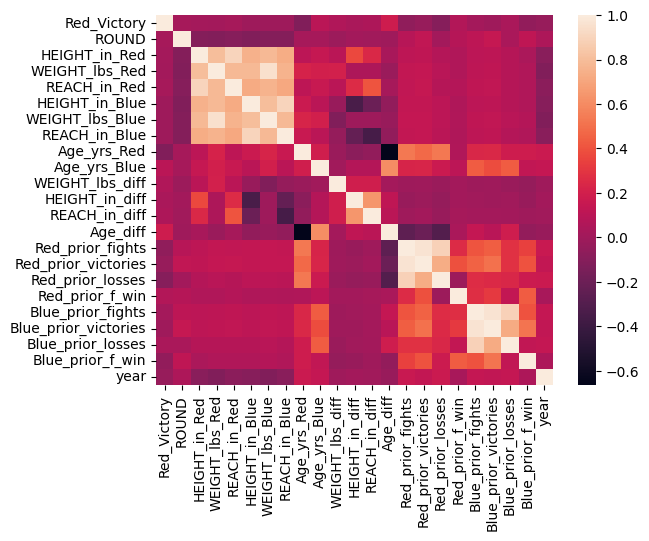

In [11]:
sns.heatmap(df.select_dtypes('number').corr())

# Baseline model

In [12]:
# Create one-hot df

df_model = pd.get_dummies(df)
df_model

,Red_Victory,ROUND,HEIGHT_in_Red,WEIGHT_lbs_Red,REACH_in_Red,HEIGHT_in_Blue,WEIGHT_lbs_Blue,REACH_in_Blue,Age_yrs_Red,Age_yrs_Blue,...,STANCE_diff_Orthodox_Orthodox,STANCE_diff_Orthodox_Southpaw,STANCE_diff_Orthodox_Switch,STANCE_diff_Southpaw_Open Stance,STANCE_diff_Southpaw_Orthodox,STANCE_diff_Southpaw_Southpaw,STANCE_diff_Southpaw_Switch,STANCE_diff_Switch_Orthodox,STANCE_diff_Switch_Southpaw,STANCE_diff_Switch_Switch
0,1.0,5,69.0,125.0,68.0,67.0,125.0,70.000000,32.156938,24.709780,...,False,False,False,False,True,False,False,False,False,False
1,0.0,3,73.0,185.0,74.0,70.0,185.0,73.000000,36.811412,33.624466,...,True,False,False,False,False,False,False,False,False,False
2,1.0,3,75.0,170.0,80.0,72.0,170.0,77.000000,35.781952,30.853685,...,True,False,False,False,False,False,False,False,False,False
3,1.0,2,70.0,155.0,72.0,67.0,155.0,70.000000,30.642865,30.188369,...,False,False,False,False,False,False,False,True,False,False
4,1.0,3,73.0,170.0,74.0,71.0,170.0,72.000000,37.783375,34.158362,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6612,1.0,1,72.0,170.0,72.0,69.0,155.0,71.000000,27.713284,29.325923,...,False,True,False,False,False,False,False,False,False,False
6613,1.0,1,73.0,145.0,73.0,70.0,155.0,71.587467,25.687219,21.761034,...,True,False,False,False,False,False,False,False,False,False
6614,1.0,1,72.0,185.0,71.0,73.0,185.0,76.000000,31.896835,32.285620,...,True,False,False,False,False,False,False,False,False,False
6615,1.0,2,69.0,170.0,71.0,72.0,170.0,74.000000,24.767276,34.292520,...,True,False,False,False,False,False,False,False,False,False


In [13]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['Red_Victory'])
y = df_model['Red_Victory']


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.600625

In [15]:
df.Red_Victory.mean()

np.float64(0.58074097233078)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.600625

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53       685
         1.0       0.65      0.65      0.65       915

    accuracy                           0.60      1600
   macro avg       0.59      0.59      0.59      1600
weighted avg       0.60      0.60      0.60      1600

[[366 319]
 [320 595]]


# Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

clf = DecisionTreeClassifier()

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)

# Train the model
clf = clf.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53       685
         1.0       0.65      0.65      0.65       915

    accuracy                           0.60      1600
   macro avg       0.59      0.59      0.59      1600
weighted avg       0.60      0.60      0.60      1600

[[366 319]
 [320 595]]


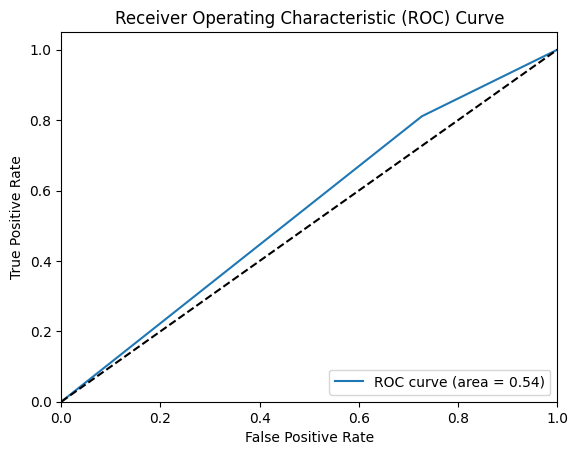

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

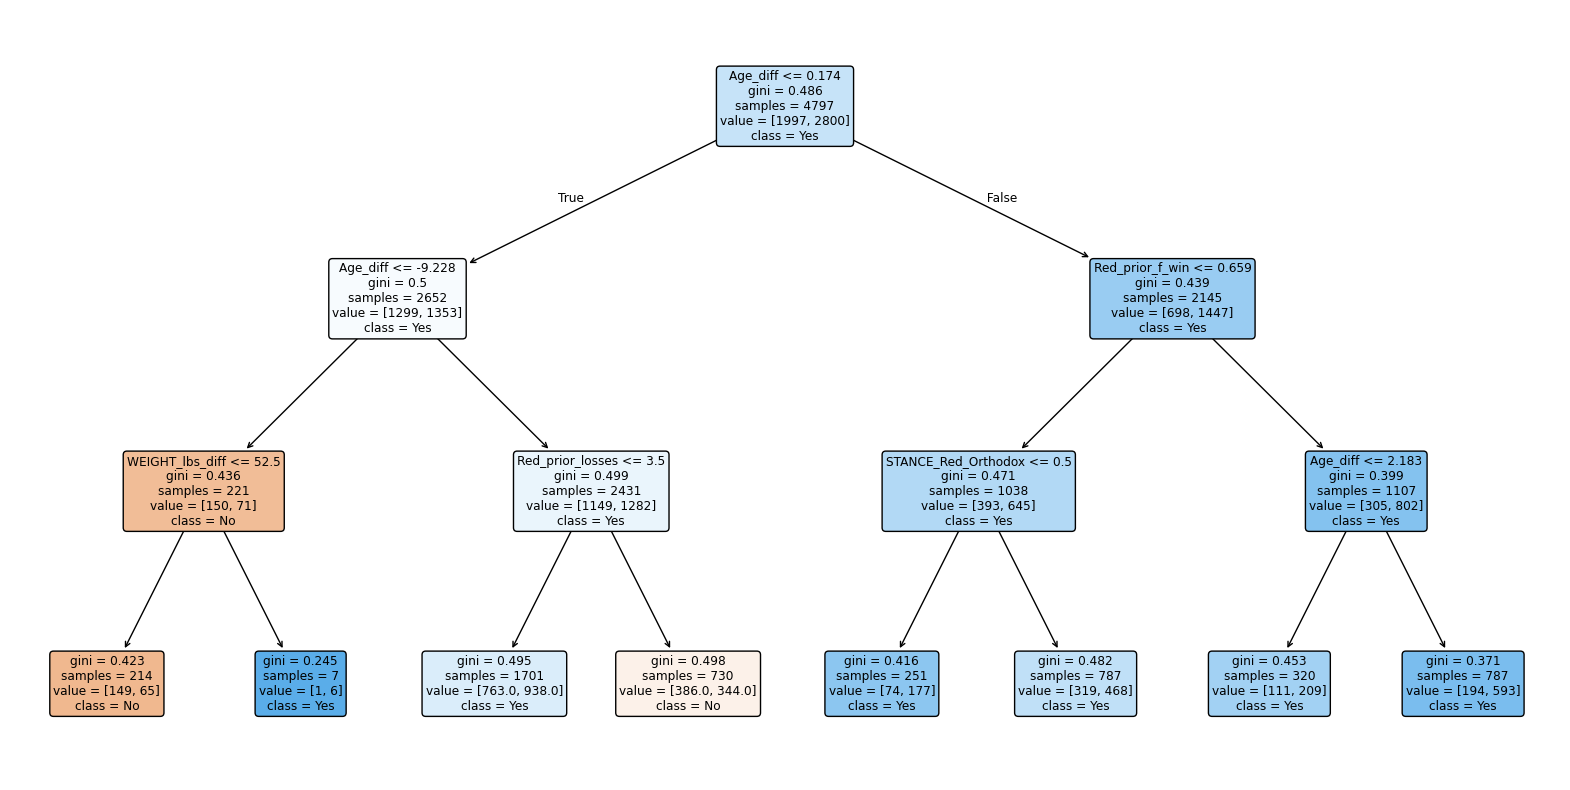

In [19]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=X.columns)
plt.show()

In [22]:
(0.6-0.58) / 0.58

0.03448275862068969

# RF

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

clf.feature_importances_

Accuracy: 0.580625


array([0.01448384, 0.02460891, 0.01836739, ..., 0.0019427 , 0.00080466,
       0.00037345])